# Low-Rank Structure in Gaussian Covariances

This notebook explores how low-rank changes in Gaussian coefficient matrices affect covariance structure.
The emphasis is on empirical covariance, eigenvalues, and matrix rank.

## Background

$$
x = W z + \varepsilon,\quad z \sim \mathcal{N}(0, I_k),\quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I_d)
$$

$$
\Sigma = W W^\top + \sigma^2 I_d.
$$

# **Setup & Import**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **Define parameters**

In [19]:
rng = np.random.default_rng(42)
d = 40
k = 8
sigma = 0.1
n = 15000

W0 = rng.normal(size=(d, k))
Sigma0 = W0 @ W0.T + sigma**2 * np.eye(d)

## **Choose rank and create low-rank update**

In [20]:
r = 2

# Create low-rank update ΔW = B @ A
B = rng.normal(size=(d, r))
A = rng.normal(size=(r, k))
Delta_LR = B @ A

# Scale the update so the change is noticeable
scale_factor = 4.0          # ← try 3.0, 4.0 or 5.0 if 4.0 is still too subtle
Delta_LR = scale_factor * Delta_LR

norm_LR = np.linalg.norm(Delta_LR, 'fro')
print(f"Low-rank update (r={r}) Frobenius norm: {norm_LR:.4f}")

Low-rank update (r=2) Frobenius norm: 99.7695


# **Create diffuse update with same Frobenius norm**

In [21]:
Delta_diffuse = rng.normal(size=(d, k))

# Scale diffuse update to match the same Frobenius norm
norm_raw = np.linalg.norm(Delta_diffuse, 'fro')
scale = norm_LR / norm_raw if norm_raw > 0 else 1.0
Delta_diffuse = scale * Delta_diffuse

norm_diffuse = np.linalg.norm(Delta_diffuse, 'fro')
print(f"Diffuse update Frobenius norm: {norm_diffuse:.4f}")
print(f"Norm ratio (should be ≈1): {norm_diffuse / norm_LR:.6f}")

Diffuse update Frobenius norm: 99.7695
Norm ratio (should be ≈1): 1.000000


# **Define the three weight matrices**

In [22]:
W_ref      = W0
W_lowrank  = W0 + Delta_LR
W_diffuse  = W0 + Delta_diffuse

# **Function to generate samples and compute empirical covariance**

In [23]:
def generate_and_compute_cov(W, n_samples, sigma, seed=42):
    rng_local = np.random.default_rng(seed)

    z = rng_local.normal(size=(n_samples, k))          # latents
    x = z @ W.T                                        # deterministic part
    noise = sigma * rng_local.normal(size=(n_samples, d))
    x = x + noise

    # Center
    x_mean = np.mean(x, axis=0, keepdims=True)
    x_centered = x - x_mean

    # Sample covariance (unbiased)
    S = (x_centered.T @ x_centered) / (n_samples - 1)

    return S

# **Generate the three empirical covariances**

In [24]:
print("Generating samples...")

S_ref      = generate_and_compute_cov(W_ref,      n, sigma, seed=42)
S_lowrank  = generate_and_compute_cov(W_lowrank,  n, sigma, seed=43)   # different seed avoids exact same noise
S_diffuse  = generate_and_compute_cov(W_diffuse,  n, sigma, seed=44)

print("Covariances computed.")

Generating samples...
Covariances computed.


# **Compute sorted eigenvalues**

In [25]:
def get_sorted_eigenvalues(S):
    # Use eigh because covariance is symmetric
    eigenvalues = np.linalg.eigh(S)[0]           # ascending order
    sorted_eigs = eigenvalues[::-1]              # flip → descending
    return sorted_eigs

eigs_ref      = get_sorted_eigenvalues(S_ref)
eigs_lowrank  = get_sorted_eigenvalues(S_lowrank)
eigs_diffuse  = get_sorted_eigenvalues(S_diffuse)

# **Plot everything (log scale)**

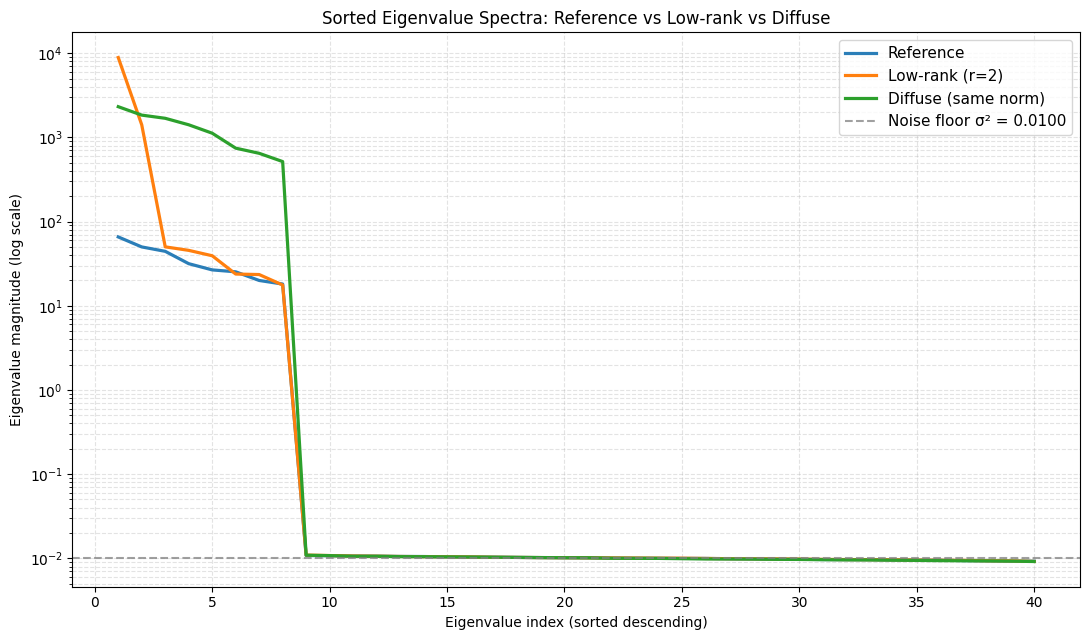

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6.5))

x_axis = np.arange(1, d+1)

plt.semilogy(x_axis, eigs_ref,      label='Reference',      lw=2.3, alpha=0.95)
plt.semilogy(x_axis, eigs_lowrank,  label=f'Low-rank (r={r})', lw=2.3)
plt.semilogy(x_axis, eigs_diffuse,  label='Diffuse (same norm)', lw=2.3)

plt.axhline(y=sigma**2, color='gray', ls='--', alpha=0.75,
            label=f'Noise floor σ² = {sigma**2:.4f}')

plt.xlabel('Eigenvalue index (sorted descending)')
plt.ylabel('Eigenvalue magnitude (log scale)')
plt.title('Sorted Eigenvalue Spectra: Reference vs Low-rank vs Diffuse')
plt.legend(frameon=True, fontsize=11)
plt.grid(True, which="both", ls="--", alpha=0.35)
plt.tight_layout()
plt.show()

Observation from the plot

Low-rank update (r=2): Exactly two eigenvalues changed significantly. The orange curve deviates sharply upward from the reference (blue) at the first two indices and then quickly rejoins the reference curve, showing a concentrated “spike” pattern.
Diffuse update: Approximately 7–8 eigenvalues changed significantly. The green curve remains consistently elevated above the reference across a much wider range (roughly indices 1 through 8–9) before dropping to the noise floor, producing a broader, more uniform lift.

Question 1 – Why does the low-rank update only affect a few eigenvalues?
In the low-rank case, only about two eigenvalues changed substantially, which directly corresponds to the rank r=2 of the update ΔW = BA. Because the update is mathematically restricted to a 2-dimensional subspace, it can only inject significant additional variance into two principal directions, leaving the remaining eigenvalues (and their corresponding directions) almost unchanged compared to the reference distribution.

Question 2 – Why does the diffuse update affect many more eigenvalues?
In the diffuse case, many more eigenvalues (roughly 7–8) are affected because the full-rank (or high-rank) modification spreads the same total energy across all available directions. Even though the Frobenius norm is identical to the low-rank update, that energy is distributed instead of concentrated, resulting in a smaller but broader increase across a large portion of the eigenvalue spectrum.

Question 3 – Overall insight
These observations illustrate that the rank of the update acts as a structural bottleneck on how the variance of the distribution can evolve. A low-rank update allows us to strongly modify only a small number of key geometric directions (the top few eigenvalues) without substantially disturbing the rest of the model’s learned structure, whereas a diffuse / full-rank update lacks this specificity and alters variance more globally across many directions.

# **Numerical quantification**

In [27]:
def count_significant_changes(ref, new, threshold=0.20):
    rel_diff = np.abs(new - ref) / (ref + 1e-10)   # avoid division by zero
    changed = rel_diff > threshold
    return np.sum(changed), np.where(changed)[0]

# Example threshold 20%
num_lr, idx_lr = count_significant_changes(eigs_ref, eigs_lowrank, 0.20)
num_diff, idx_diff = count_significant_changes(eigs_ref, eigs_diffuse, 0.20)

print(f"Low-rank (threshold 20%): {num_lr} eigenvalues changed significantly")
print(f"  Indices: {idx_lr.tolist()}")
print(f"Diffuse (threshold 20%): {num_diff} eigenvalues changed significantly")
print(f"  Indices: {idx_diff.tolist()}")

Low-rank (threshold 20%): 4 eigenvalues changed significantly
  Indices: [0, 1, 3, 4]
Diffuse (threshold 20%): 8 eigenvalues changed significantly
  Indices: [0, 1, 2, 3, 4, 5, 6, 7]
